In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')
import myAnalyses.lowmag_analysis_OSS as dio

DEFINE FILE PATHS

In [2]:

path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/glass/Fused_Red_24-02-12_080-083/'
#path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/agar/23-12-04_2_Fused_NoCompute_550_1000/'

path_to_image_stack = path + r'*.tif'

base = '2024_02_12_glass_olympus_x4_10sec_1in400_080_83'
#base = '2023_12_04_agar_olympus_x4_5sec_2'
#base = 'buckling'



DEFINE PARAMETERS FOR THE ANALYSIS

In [3]:

### ACQUISITION PARAMETERS - FIXED BY THE MICROSCOPY ###
#um_per_px = 1/1.198    #optoscope 10x obj.    
um_per_px = 1.61        #olympus x4 obj.
delta_t = 10 # seconds
#delta_t = 5 # seconds      

#### FILAMENT DETECTION PARAMAETERS - TO BE OPTIMISED FOR EACH MOVIE ###
#threshold for creating binary image, which the contour algorithm will use
#NOTE: the threshold coefficient should be experimented with here to get good contour detection
#change this parameter and explore effects in section 2 - do so, for a bunch of frames!
#coeffForThresh = 0.98 #decide a good coefficient. Values that usually work are 0.97, 1, or 1.1
coeffForThresh = 0.98

#minimum area - as returned from the contour finding algorithm - to consider a filament
areaThreshold = 10

#spline parameters. This is for the spline algorithm, used in section 2 (and then 3)
#experiment with this parameter and check effects in section 2 - do so, for a bunch of frames!
#smooth_spline = 10.0 # smoothness parameter
smooth_spline = 15.0 # smoothness parameter
#k_order_spline = 1 # spline order
k_order_spline = 3 # spline order
nest = -1 # estimate of number of knots needed (-1 = maximal)

#filament orientation to use for fitting spline
# NOTE: we need to make sure that "EndA" is the left/bottom end (red)
#and "EndB" is the right/top end (blue)
#set following to true if you want to force use of NS orientation to ensure this.
#if set false, code will automatically decide with orientation to use based on which 
#gives a longer filament fit. Decide how to use, based on section 2 result
#basically, use True if filament is clearly NS and top end is to the left or straight up
forceUseNS = False

#sample frame to plot
frameid=0

#smoothing range - larger the less noisy 
#NOTE: we prefer less noisy for dwell time calc. 
#More noisy (i.e. raw) speed data tends to break up reversals into several pieces, resulting in
#shorter dwell times. This is because speed profile has peaks in it. Overall, you can decide the right 
#amount of smoothing based on how many reversals (i.e. dwell times) you get and how many you see in the
#position data or the actual filament movie.
#following value seems to work well, but check for each filament
howsmooth = 10
poly_order = 3



In [1]:
24*1000/9152

2.6223776223776225

LOAD TIMELAPSE, CHECK TYPE

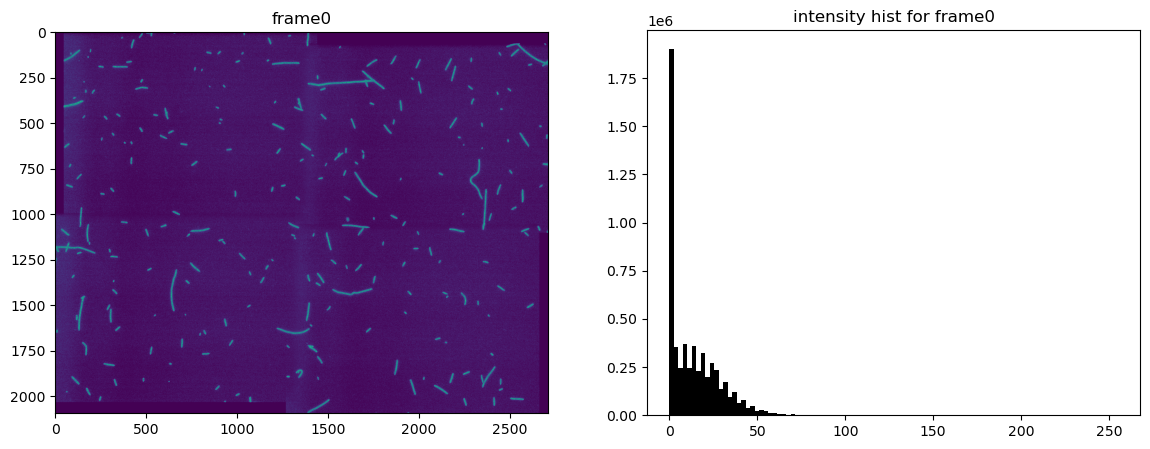

In [4]:

#open image stack
frames = pims.open(path_to_image_stack)

#convert image datatype to uint8
frames1 = pims.pipeline(lambda x: x.astype(np.uint8))(frames)  #convert to uint8 
frames = frames1

# Plot a test frame and show the histogram
fig, ax = plt.subplots(1,2, figsize=(14,5))
frame = frames[frameid]
#ax[0].imshow(frame, vmin=0, vmax=1, cmap='Reds')
ax[0].imshow(frame)
ax[0].set_title(str('frame'+str(frameid)))
n_0, bins_0, patches_0 = ax[1].hist(frame.flat, bins = 100, color='black')
ax[1].set_title(str('intensity hist for frame'+str(frameid)))
plt.show()
#frames3
#frame[10].dtype

CHECK FILAMENT DETECTION ON ONE FRAME

/var/folders/gv/q0hyps757tjd5c_j0dwtgghc0000gq/T/ipykernel_2924/3401125051.py:83: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


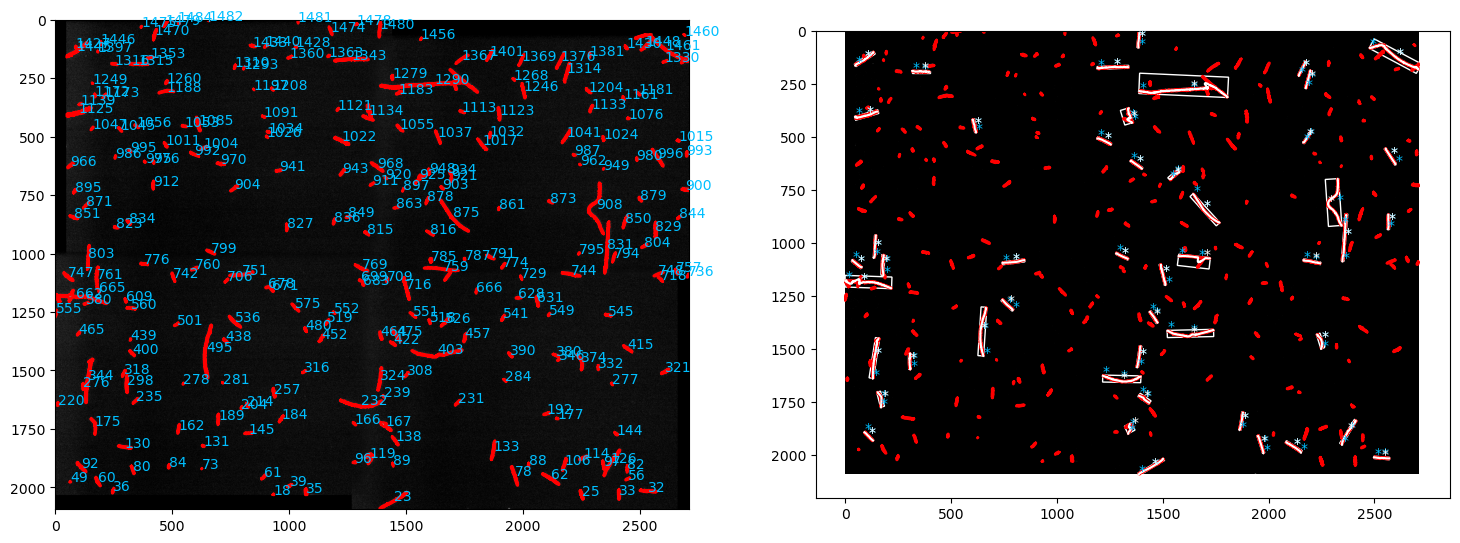

In [6]:

#pick one frame
frame=frames[0]

#  yen threshold the image
thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution: all values above threshold considered foreground (for black background images)
binary = frame > (coeffForThresh*thresh)          
frame_thresholded = binary*frame


#find contours in the frame, to get the filament
contours = cv2.findContours(frame_thresholded,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)    #note that this finds all the contours
cnts = imutils.grab_contours(contours)                                                      #get all contours that are found

#plot image with detected contours drawn
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame,cmap="gray")
counter = 0
#go through each detected contour 
for cnt in cnts:
    x1 = cnt[:,0,0]                                                                            
    y1 = cnt[:,0,1]
    if (cv2.contourArea(cnt)>areaThreshold):    #if contour area is above threshold, draw it
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        ax[0].plot(x1[:],y1[:],color='red')                         #plotting the contour
        ax[0].annotate(counter,xy=(cx,cy),color='deepskyblue')      #add label, where centre of moment is
    counter+=1

#plot image with only detected contours with area above 400 drawn
filamentCounter = 0
ax[1].imshow(frame_thresholded,cmap="gray")
for cnt in cnts:
    x1 = cnt[:,0,0]                                                                             #x and y coordinates of the contour
    y1 = cnt[:,0,1]
    if (cv2.contourArea(cnt)>areaThreshold):    #if contour area is above threshold, draw it
        ax[1].plot(x1[:],y1[:],color='red') #plotting one side of contour
    if (cv2.contourArea(cnt)>400): #fit a line to the contour and draw that line
        
        #get the extreme ends of the contour
        extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
        extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
        extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
        extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
        
        #using the extreme points, get the points making each half of the contour, i.e. each side of the filament
        #do this for both orientations, north-south and east-west
        indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio.get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)
        xSideA_EW, ySideA_EW, xSideB_EW, ySideB_EW = dio.getMidSplineFromCorners_OSS(x1, y1, indexforLeftCorner, indexforRightCorner)
        xSideA_NS, ySideA_NS, xSideB_NS, ySideB_NS = dio.getMidSplineFromCorners_OSS(x1, y1, indexforBottomCorner, indexforTopCorner)
        
        #fit splines to each half side (using both NS and EW orientation results) and create mid-spline. Pick the case with longer filament
        filamentLength_EW_inPx, filamentDist_EW_inPx = 0, 0
        filamentLength_NS_inPx, filamentDist_NS_inPx = 0, 0
        xn_M_EW, yn_M_EW, midSpline_Ti_EW = [], [], []
        xn_M_NS, yn_M_NS, midSpline_Ti_NS = [], [], []
        xn_M, yn_M, midSpline_Ti = [], [], []
        if (len(xSideA_EW)>3 and len(xSideB_EW)>3): 
            xn_M_EW, yn_M_EW, midSpline_Ti_EW = dio.getMidSplineFromContourSides_OSS(xSideA_EW, ySideA_EW, xSideB_EW, ySideB_EW,smooth_spline,k_order_spline,nest)
            filamentLength_EW_inPx = dio.get_filamentLength_OSS(midSpline_Ti_EW)
            filamentDist_EW_inPx = np.sqrt((xn_M_EW[0]-xn_M_EW[-1])**2 + (yn_M_EW[0]-yn_M_EW[-1])**2)
        if (len(xSideA_NS)>3 and len(xSideB_NS)>3): 
            xn_M_NS, yn_M_NS, midSpline_Ti_NS = dio.getMidSplineFromContourSides_OSS(xSideA_NS, ySideA_NS, xSideB_NS, ySideB_NS,smooth_spline,k_order_spline,nest)
            filamentLength_NS_inPx = dio.get_filamentLength_OSS(midSpline_Ti_NS)
            filamentDist_NS_inPx = np.sqrt((xn_M_NS[0]-xn_M_NS[-1])**2 + (yn_M_NS[0]-yn_M_NS[-1])**2)
        if (filamentDist_NS_inPx > filamentDist_EW_inPx):
            xn_M, yn_M, midSpline_Ti = xn_M_NS, yn_M_NS, midSpline_Ti_NS
        else:
            xn_M, yn_M, midSpline_Ti = xn_M_EW, yn_M_EW, midSpline_Ti_EW
        
        #get the mid point of countour
        xCentre, yCentre, xCentre2, yCentre2 = dio.getMidPointOfContour_OSS(x1,y1)

        ax[1].annotate("*",xy=(xn_M[0],yn_M[0]),color='deepskyblue')
        ax[1].annotate("*",xy=(np.median(x1),np.median(y1)),color='deepskyblue')
        ax[1].annotate("*",xy=(xCentre,yCentre),color='white')
        ax[1].plot(xn_M[:],yn_M[:],color='white') #plotting one side of contour

        #fit a box to the contour and draw that box
        x,y,w,h = cv2.boundingRect(cnt)
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        rect = patches.Polygon(box, linewidth=1, edgecolor='white', facecolor='none')
        ax[1].add_patch(rect)

    filamentCounter += 1

LOOP THROUGH FRAMES, FIT SPLINE TO FILAMENT, IDENTIFY END POINTS AND CALCULATE SPEED, ETC.

In [8]:

#array to store the frame ID, filament ID, filament length, and end point x, end point y
filamentData = np.empty(shape=[0, 5])

#defining a counter for frames
frameCounter = 0

#main loop through frames of the timalapse
for frame in frames:
    skipFrame = False
    # yen threshold the frame
    thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution
    binary = frame > (coeffForThresh*thresh)          
    frame_thresholded = binary*frame

    #find contours in the frame, to get the filaments
    contours = cv2.findContours(frame_thresholded,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)

    #defining counters for filaments
    filamentCounter = 0
    nEligibleFilaments = 0
    filamentLenghts = 0
    
    #loop through contours
    for cnt in cnts:
        x1 = cnt[:,0,0]                                                         
        y1 = cnt[:,0,1]
        skipFilament = False
        if (cv2.contourArea(cnt)>areaThreshold): 
            
            #get moment of contour
            M = cv2.moments(cnt)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
                
            #get the four extreme points (i.e. corners) of the contour
            extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0]) #smallest x-coordinate
            extRight = tuple(cnt[cnt[:, :, 0].argmax()][0]) #largest x-coordinate
            extTop = tuple(cnt[cnt[:, :, 1].argmin()][0]) #smallest y-coordinate
            extBot = tuple(cnt[cnt[:, :, 1].argmax()][0]) ##largest y-coordinate
            indexforRightCorner, indexforLeftCorner, indexforTopCorner, indexforBottomCorner = dio. get_indicesForCorners_OSS(cnt, extRight, extLeft, extTop, extBot)

            #using the extreme points, get the points making each half of the contour, i.e. each side of the filament
            #do this for both orientations, north-south and east-west
            xSideA_Ti_EW, ySideA_Ti_EW, xSideB_Ti_EW, ySideB_Ti_EW = dio.getMidSplineFromCorners_OSS(x1, y1, indexforLeftCorner, indexforRightCorner)
            xSideA_Ti_NS, ySideA_Ti_NS, xSideB_Ti_NS, ySideB_Ti_NS = dio.getMidSplineFromCorners_OSS(x1, y1, indexforBottomCorner, indexforTopCorner)
    
            #fit splines to each half side (using both NS and EW orientation results) and create mid-spline. 
            filamentLength_EW_inPx = 0
            filamentLength_NS_inPx = 0
            filamentLength = 0
            usingEWorientation = False
            usingNSorientation = False
            if (len(xSideA_Ti_NS)>5 and len(xSideB_Ti_NS)>5):  
                xn_M_NS, yn_M_NS, midSpline_Ti_NS = dio.getMidSplineFromContourSides_OSS(xSideA_Ti_NS, ySideA_Ti_NS, xSideB_Ti_NS, ySideB_Ti_NS,smooth_spline,k_order_spline,nest)
                filamentLength_NS_inPx = dio.get_filamentLength_OSS(midSpline_Ti_NS)
            if (len(xSideA_Ti_EW)>5 and len(xSideB_Ti_EW)>5 and forceUseNS != True): 
                xn_M_EW, yn_M_EW, midSpline_Ti_EW = dio.getMidSplineFromContourSides_OSS(xSideA_Ti_EW, ySideA_Ti_EW, xSideB_Ti_EW, ySideB_Ti_EW,smooth_spline,k_order_spline,nest)
                filamentLength_EW_inPx = dio.get_filamentLength_OSS(midSpline_Ti_EW)

            #decide which orientation to use, based on length of midline. Pick the case with longer filament
            filamentDist_NS_inPx = np.sqrt((xn_M_NS[0]-xn_M_NS[-1])**2 + (yn_M_NS[0]-yn_M_NS[-1])**2)
            filamentDist_EW_inPx = np.sqrt((xn_M_EW[0]-xn_M_EW[-1])**2 + (yn_M_EW[0]-yn_M_EW[-1])**2)

            if (filamentDist_NS_inPx >= filamentDist_EW_inPx):
                xn_M, yn_M, midSpline_Ti = xn_M_NS, yn_M_NS, midSpline_Ti_NS
                filamentLength = filamentLength_NS_inPx*um_per_px        #store filament length as cumulative distance on the mid-point spline. NOTE: we convert pixels to microns at this point.
                usingNSorientation = True
            else:
                xn_M, yn_M, midSpline_Ti = xn_M_EW, yn_M_EW, midSpline_Ti_EW
                filamentLength = filamentLength_EW_inPx*um_per_px        #store filament length as cumulative distance on the mid-point spline. NOTE: we convert pixels to microns at this point.
                usingEWorientation = True

            #alternative filament length - using built-in function
            filamentLength_alt = cv2.arcLength(cnt,True)/2

            #check for issues with this filament
            if (usingNSorientation+usingEWorientation==False):
            #    print ('something fishy in frame: %d, filament %d, as filamentLength, inPx, estimate are: %d, %f ,' % (frameCounter, filamentCounter, forceUseNS, filamentLength))
            #    print ('length of midlineSpline: %f, %f, %f' % (len(midSpline_Ti),midSpline_Ti[10,0],midSpline_Ti[30,0]))
                skipFilament = True
            
            if (usingNSorientation == True and np.abs(len(xSideA_Ti_NS) + len(xSideB_Ti_NS) - len(x1)) > len(x1)/10):
            #    print ('something fishy in frame: %d, filament %d. Using NS, but contour side lengths NS are: %f , %f, %f, %d' % (frameCounter, filamentCounter, len(xSideA_Ti_NS), len(xSideB_Ti_NS), len(x1), usingNSorientation))
                skipFilament = True
            
            if (usingEWorientation == True and np.abs(len(xSideA_Ti_EW) + len(xSideB_Ti_EW) - len(x1)) > len(x1)/10):
            #    print ('something fishy in frame: %d, filament %d. Using EW, but contour side lengths EW are: %f , %f, %f, %d' % (frameCounter, filamentCounter, len(xSideA_Ti_EW), len(xSideB_Ti_EW), len(x1), usingEWorientation))
                skipFilament = True

            #if no isses, then store filament info: frame ID, filament ID, filament length, and end point x, end point y
            #notice that we use fitted spline approach for recorded filament length, but for tracking filament, we use moments.    
            if (skipFilament == False):
                #filamentData = np.append(filamentData,[[frameCounter, filamentCounter, filamentLength, xn_M[0], yn_M[0]]],axis=0)
                #filamentData = np.append(filamentData,[[frameCounter, filamentCounter, filamentLength, cx, cy]],axis=0)
                #filamentData = np.append(filamentData,[[frameCounter, filamentCounter, filamentLength,  np.median(x1),  np.median(y1)]],axis=0)
                #get the mid point of countour
                xCentre, yCentre, xCentre2, yCentre2 = dio.getMidPointOfContour_OSS(x1,y1)
                filamentData = np.append(filamentData,[[frameCounter, filamentCounter, filamentLength, xCentre, yCentre]],axis=0)
                #filamentData = np.append(filamentData,[[frameCounter, filamentCounter, filamentLength_alt, cx, cy]],axis=0)
                nEligibleFilaments += 1
                filamentLenghts += filamentLength

        filamentCounter += 1

    print ('Frame %d, has %d filaments, of which %d are eligible. Mean length of eligible filaments is: %f' % (frameCounter, filamentCounter, nEligibleFilaments, filamentLenghts/nEligibleFilaments))
    frameCounter += 1
#Next lines are just printing out stuff for debugging


Frame 0, has 1485 filaments, of which 242 are eligible. Mean length of eligible filaments is: 76.057423
Frame 1, has 1604 filaments, of which 252 are eligible. Mean length of eligible filaments is: 73.237034
Frame 2, has 1498 filaments, of which 252 are eligible. Mean length of eligible filaments is: 73.201660
Frame 3, has 1645 filaments, of which 251 are eligible. Mean length of eligible filaments is: 75.432035
Frame 4, has 1574 filaments, of which 252 are eligible. Mean length of eligible filaments is: 72.877670
Frame 5, has 1586 filaments, of which 254 are eligible. Mean length of eligible filaments is: 72.414516
Frame 6, has 1698 filaments, of which 250 are eligible. Mean length of eligible filaments is: 73.424225
Frame 7, has 1630 filaments, of which 254 are eligible. Mean length of eligible filaments is: 72.143194
Frame 8, has 1662 filaments, of which 251 are eligible. Mean length of eligible filaments is: 72.960698
Frame 9, has 1317 filaments, of which 246 are eligible. Mean len

KeyboardInterrupt: 

JUST A QUICK ANALYSIS OF AVERAGES ON FOUND FILAMENTS

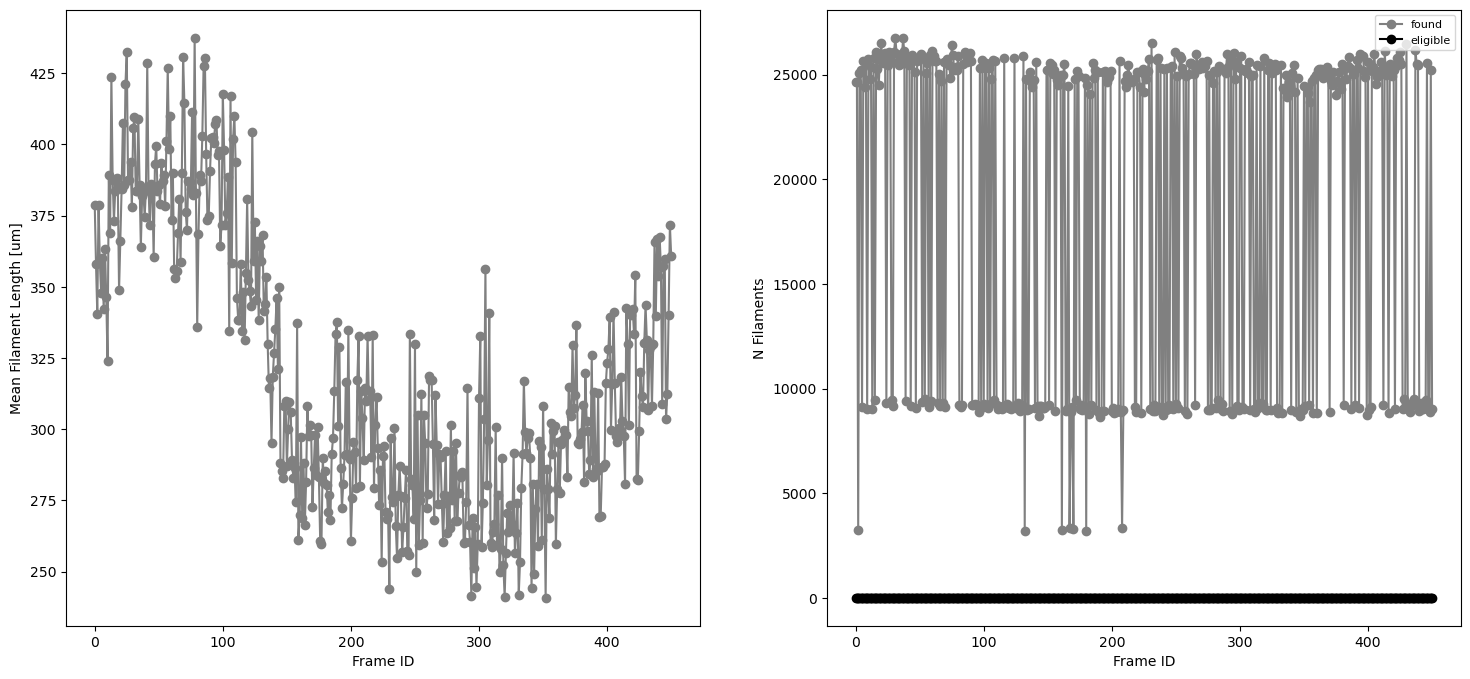

In [7]:
#create counter and data frame to hold averages
frameCounter = 0
frameData = np.empty(shape=[0, 3])

#loop through frames and distill from recorded data the average filament length for each frame and the total number of filaments
for frame in frames:
    filamentData_Frame = filamentData[filamentData[:,0] == frameCounter]
    frameData = np.append(frameData,[[np.mean(filamentData_Frame[:,2]),filamentData_Frame[-1,1],len(filamentData_Frame[:,0])]], axis=0)
    frameCounter += 1

#create dummy x-axis (for number of frames) and plot averages
myxaxis = np.arange(0, frameCounter,1)
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].plot(myxaxis, frameData[:,0],marker='o', color='gray')
ax[0].set_ylabel('Mean Filament Length [um]')
ax[0].set_xlabel('Frame ID')
ax[1].plot(myxaxis, frameData[:,1],marker='o', color='gray', label="found")
ax[1].plot(myxaxis, frameData[:,2],marker='o', color='black', label="eligible")
ax[1].set_ylabel('N Filaments')
ax[1].set_xlabel('Frame ID')
ax[1].legend(loc="upper right",fontsize=8)


PLOT THE FIRST IMAGE AND SHOW ON THIS THE IDENTIFIED FILAMENTS AND THEIR RECORDED IDS

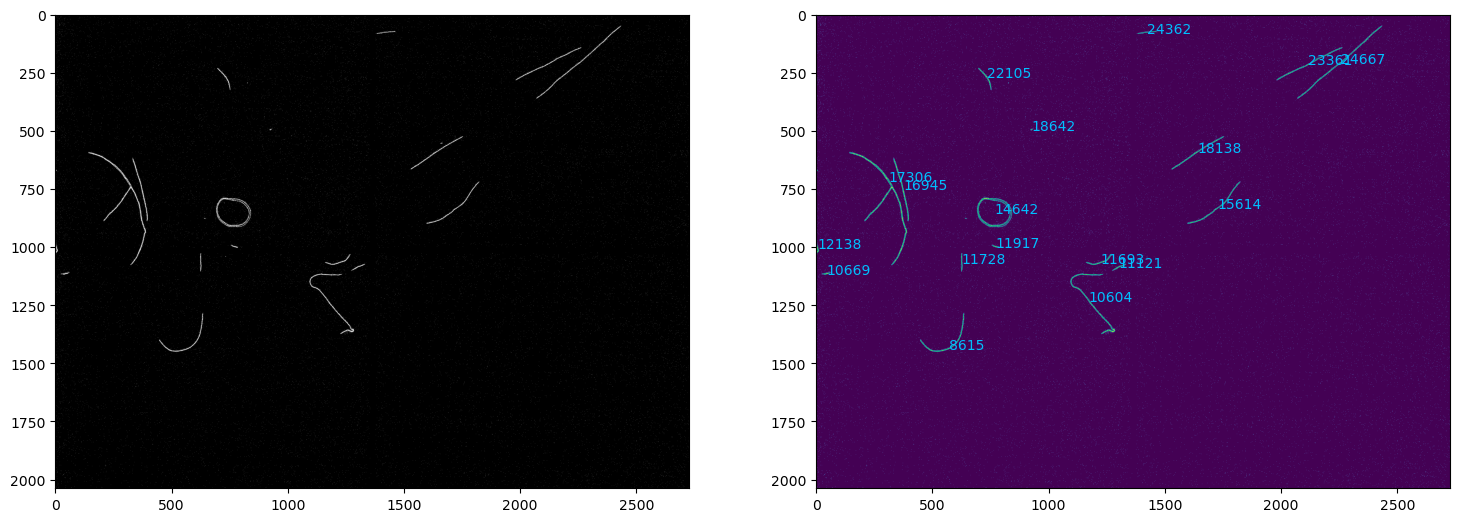

In [8]:
frameid=0
#pick recorded data for frame 0
filamentData_Frame = filamentData[filamentData[:,0] == frameid]  

#pick frame 0 and threshold the image
frame=frames[frameid]
thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution: all values above threshold considered foreground (for black background images)
binary = frame > (coeffForThresh*thresh)          
frame_thresholded = binary*frame

#plot the thresholded image and label identified filaments and their recorded IDs
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame_thresholded,cmap="gray")
ax[1].imshow(frame_thresholded)
for i in range(0,len(filamentData_Frame[:,0])):
    ax[1].annotate(int(filamentData_Frame[i,1]),xy=(filamentData_Frame[i,3],filamentData_Frame[i,4]),color='deepskyblue')


USE THE ABOVE IMAGE AND THE MOVIE TO IDENTIFY A CANDIDATE FILAMENT TO ANALYSE

In [9]:
#pick a filament in frame 0, find it in subsequent frames using distance among its x,y coordinates

#array to store x,y locations from each frame
filamentData_overTime = np.empty(shape=[0, 5])


#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_080_83_0_300'
#choose a filament using its ID   
#chosenFilamentID = 106
#chosenFilamentID = 231
#chosenFilamentID = 759 
#chosenFilamentID = 716
#chosenFilamentID = 875
#chosenFilamentID = 968
#chosenFilamentID = 850
#chosenFilamentID = 799
#chosenFilamentID = 631
#chosenFilamentID = 480
#search_range = 10 #use for all of the above filaments

#different search range for filament 133!
#chosenFilamentID = 133
#search_range = 5


#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_080_83_301_600'
#chosenFilamentID = 897
#chosenFilamentID = 461
#chosenFilamentID = 600
#chosenFilamentID = 753
#chosenFilamentID = 1245
#chosenFilamentID = 540
#chosenFilamentID = 1164
#chosenFilamentID = 143
#chosenFilamentID = 700
#chosenFilamentID = 1000
#chosenFilamentID = 1276
#chosenFilamentID = 1334
#search_range = 10 #use for all of the above filaments



#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_080_83_601_999'
#chosenFilamentID = 807
#chosenFilamentID = 528
#chosenFilamentID = 135
#search_range = 10 #use for all of the above filaments

#chosenFilamentID = 1110
#chosenFilamentID = 1260
#search_range = 5 #use for all of the above filaments



#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_064_67_0_250'
#chosenFilamentID = 70
#chosenFilamentID = 712
#chosenFilamentID = 648
#chosenFilamentID = 1002
#search_range = 10 #use for all of the above filaments

#chosenFilamentID = 556
#chosenFilamentID = 1345
#chosenFilamentID = 481
#search_range = 15 #use for all of the above filaments


#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_064_67_250_500'
#chosenFilamentID = 1917
#chosenFilamentID = 2073
#chosenFilamentID = 751
#search_range = 10 #use for all of the above filaments

#chosenFilamentID = 767
#search_range = 2 #use for all of the above filaments

#chosenFilamentID = 1642
#chosenFilamentID = 952
#chosenFilamentID = 538
#search_range = 5 #use for all of the above filaments


#FILAMENTS FOR: 2023_12_04_agar_olympus_x4_5sec_2'
#chosenFilamentID = 11693
chosenFilamentID = 8615
search_range = 10 #use for all of the above filaments


#used for all filaments above!
length_threshold_coeff = 3 #length threshold - larger it is less overlaps we would allow

#pick the recorded data for frame 0 and then pick the chosen filament's data in that data
filamentData_Frame = filamentData[filamentData[:,0] == 0]  
chosenfilament_Data = filamentData_Frame[filamentData_Frame[:,1] == chosenFilamentID] 
chosenFilament_x = chosenfilament_Data[0,3]   #get x, y, and length for that filament
chosenFilament_y = chosenfilament_Data[0,4]
chosenFilament_l = chosenfilament_Data[0,2]

#store chosen filament's data for frame 0: frameID, filamentID, length, x-pos, y-pos
filamentData_overTime = np.append(filamentData_overTime,[[chosenfilament_Data[0,0],     
                                                          chosenfilament_Data[0,1],
                                                          chosenfilament_Data[0,2],
                                                          chosenfilament_Data[0,3],             
                                                          chosenfilament_Data[0,4]]], axis=0)       

#dist threshold - larger search range, more possibility of overlapping filaments
dist_threshold = delta_t*search_range 

#length threshold - larger it is more overlaps we would allow
length_threshold = chosenFilament_l/length_threshold_coeff 

#loop through frames, skipping frame 0 and starting with frame 1
for i in range(1,len(frames)):
#for i in range(1,300):
    possibleFilaments = np.empty(shape=[0, 3])
    filamentData_Frame = filamentData[filamentData[:,0] == i]       #pick data for this frame
    filamentData_Frame2 = filamentData_Frame[np.abs(filamentData_Frame[:,2]-chosenFilament_l) < length_threshold]       #pick filaments that have similar lenght as chosen one
    
    #loop through filaments in this frame that have similar length to chosen one and calculate their distances to chosen filament and their diff in length
    for j in range(0,len(filamentData_Frame2[:,0])):                 
        diff_pos  = np.sqrt((chosenFilament_x-filamentData_Frame2[j,3])**2 + (chosenFilament_y-filamentData_Frame2[j,4])**2)
        diff_length  = np.sqrt((chosenFilament_l-filamentData_Frame2[j,2])**2)
        if (diff_pos*um_per_px<dist_threshold):     #include those within certain distance as possible match
            possibleFilaments = np.append(possibleFilaments,[[filamentData_Frame2[j,1], diff_pos, diff_length]],axis=0)
    
    #record number of possible filaments
    nFils = len(possibleFilaments[:,0])     
    if (nFils==1): filamentPick = possibleFilaments[0,0] #if one possible, pick that filament as match
    if (nFils>1): #if more than one possible filament, sort the list of possible filaments and pick the one with smallest distance
        possibleFilaments_sorted_pos = possibleFilaments[possibleFilaments[:, 1].argsort()]
        possibleFilaments_sorted_length = possibleFilaments[possibleFilaments[:, 2].argsort()]
        #filamentPick = possibleFilaments_sorted_pos[0,0]           #pick filament with closest length
        filamentPick = possibleFilaments_sorted_length[0,0]         #pick filament with closest distance

    if (nFils==0): #if no candidate filaments found, use previous filament as a placeholder entry and then convert entry to nan
        pickedfilament_Data = filamentData_Frame[filamentData_Frame[:,1] == filamentData_Frame[0,1]]
        pickedfilament_Data[0,2] = np.nan
        pickedfilament_Data[0,3] = np.nan
        pickedfilament_Data[0,4] = np.nan
    else:          #if a matching filament is decided, enter its data into record
        pickedfilament_Data = filamentData_Frame2[filamentData_Frame2[:,1] == filamentPick] 
        chosenFilament_l = pickedfilament_Data[0,2]
        chosenFilament_x = pickedfilament_Data[0,3]
        chosenFilament_y = pickedfilament_Data[0,4]
    
    #append entry into dataframe: frameID, filamentID, length, x-pos, y-pos
    filamentData_overTime = np.append(filamentData_overTime,[[pickedfilament_Data[0,0],
                                                          pickedfilament_Data[0,1],
                                                          pickedfilament_Data[0,2],
                                                          pickedfilament_Data[0,3],
                                                          pickedfilament_Data[0,4]]], axis=0)

#outputs for debugging
#pickedfilament_Data
filamentData_overTime[37:59,:]
#filamentData_Frame2
#[chosenFilament_x,chosenFilament_y]
#nFils
#len(filamentData_overTime)

array([[   37.        ,  9893.        ,   510.65386879,   440.        ,
         1385.5       ],
       [   38.        ,  9567.        ,   511.03406455,   440.5       ,
         1387.        ],
       [   39.        ,  3421.        ,   511.56652375,   436.5       ,
         1377.        ],
       [   40.        ,  9732.        ,   529.13791747,   439.5       ,
         1385.        ],
       [   41.        ,  9650.        ,   536.99145125,   437.        ,
         1377.5       ],
       [   42.        ,  9639.        ,   550.30566333,   436.        ,
         1375.5       ],
       [   43.        ,  3360.        ,   513.02290468,   433.        ,
         1364.5       ],
       [   44.        ,  9742.        ,   553.097892  ,   430.5       ,
         1350.        ],
       [   45.        , 10092.        ,   551.72683348,   430.        ,
         1351.        ],
       [   46.        ,  9697.        ,   542.33033563,   429.        ,
         1344.        ],
       [   47.        ,  3396.

PLOT RECORDED X-Y POSITION OF THE FILAMENT AND CHECK HOW GOOD THE DATA LOOKS - ANY GAPS? CHECK ALSO AGAINST MOVIE!

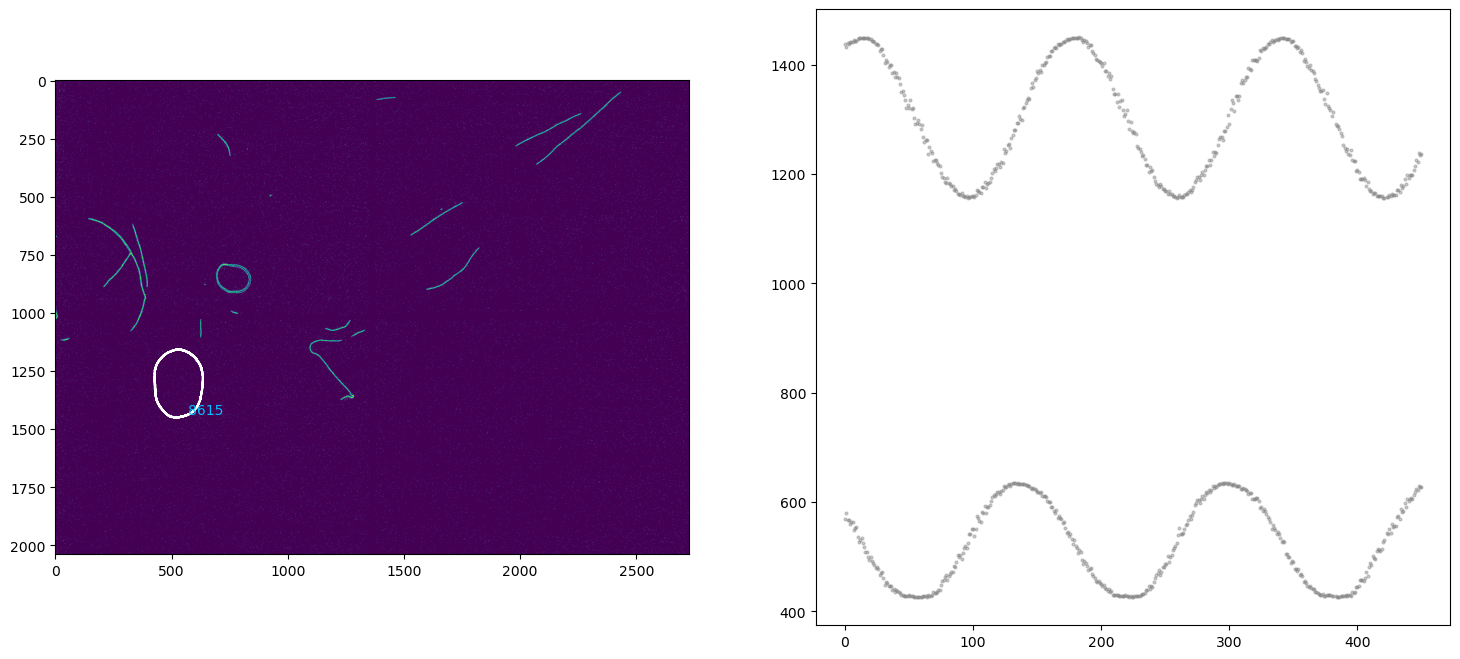

In [10]:
#pick 1st frame and yen threshold the image
frame=frames[0]
thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution: all values above threshold considered foreground (for black background images)
binary = frame > (coeffForThresh*thresh)          
frame_thresholded = binary*frame

#plot image and overlay x-y position of the chosen filament
fig, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].imshow(frame_thresholded)
ax[0].annotate(int(filamentData_overTime[0,1]),xy=(filamentData_overTime[0,3],filamentData_overTime[0,4]),color='deepskyblue')
ax[0].plot(filamentData_overTime[:,3],filamentData_overTime[:,4],color='white') #plotting one side of contour
#2D position and speed
for i in range(0,len(filamentData_overTime[:,3])):
    ax[1].scatter(filamentData_overTime[i,0],filamentData_overTime[i,3],s=4,marker='o',color='gray',alpha=0.4)
    ax[1].scatter(filamentData_overTime[i,0],filamentData_overTime[i,4],s=4,marker='o',color='gray',alpha=0.4)

WRITE RECORDED DATA FOR THE FILAMENT INTO A CSV FILE

In [12]:
# Prepare the results table
import pandas as pd
result_dict = {'FrameID': filamentData_overTime[:,0], 'FilamentID' : filamentData_overTime[:,1], 
               'filamentLength' : filamentData_overTime[:,2], 'filamentXloc' : filamentData_overTime[:,3], 'filamentYloc' : filamentData_overTime[:,4]}
result = pd.DataFrame.from_dict(result_dict)
result.head()

saveMyData= base+'_FILAMENTID_'+str(chosenFilamentID)+r'_data.csv'
f = open(saveMyData, 'a')
f.write('#comments\n #path to data %s, Pixel Size Used %f, Delta t Used %f, coeffForThresh %f, smoothSpline %f, kOrderSpline %f \n' % (path, um_per_px, delta_t, coeffForThresh, smooth_spline, k_order_spline))

# ------------------ SAVE ---------------- #
result.to_csv(f, sep='\t')
f.close()

DEFINE FILAMENT SPECIFIC ANALYSIS PARAMETERS: IN PARTICULAR, ANY PART THAT SHOULD BE EXCLUDED FROM ANALYSIS

In [11]:
#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_080_83_0_300'

#filament 759
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [500,0]
#maxSpeedUsed  = 2.25

#filament 716
#filamentData_overTime2 = filamentData_overTime[0:170,:]
#nanIndices = np.argwhere(np.isnan(filamentData_overTime2[:,3]))
#filamentData_overTime_clean = filamentData_overTime2[~np.isnan(filamentData_overTime2[:,3])]
#fixedPoint = [1500,0]
#maxSpeedUsed  = 2

#filament 875
#filamentData_overTime2 = filamentData_overTime[0:100,:]
#nanIndices = np.argwhere(np.isnan(filamentData_overTime2[:,3]))
#filamentData_overTime_clean = filamentData_overTime2[~np.isnan(filamentData_overTime2[:,3])]
#fixedPoint = [1500,250]
#maxSpeedUsed  = 2

#filament 968
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [1000,250]
#maxSpeedUsed  = 1

#filament 850
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [2500,1250]
#maxSpeedUsed  = 0.7

#filament 799
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [500,1500]
#maxSpeedUsed  = 1

#filament 631
#filamentData_overTime2 = filamentData_overTime[0:150,:]
#nanIndices = np.argwhere(np.isnan(filamentData_overTime2[:,3]))
#filamentData_overTime_clean = filamentData_overTime2[~np.isnan(filamentData_overTime2[:,3])]
#fixedPoint = [2000,1000]
#maxSpeedUsed  = 1

#filament 480
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [1000,1000]
#maxSpeedUsed  = 1

#filament 133
#filamentData_overTime2 = filamentData_overTime[0:200,:]
#nanIndices = np.argwhere(np.isnan(filamentData_overTime2[:,3]))
#filamentData_overTime_clean = filamentData_overTime2[~np.isnan(filamentData_overTime2[:,3])]
#fixedPoint = [1900,2000]
#maxSpeedUsed  = 1

#filament 106
#filamentData_overTime2 = filamentData_overTime[0:240,:]
#nanIndices = np.argwhere(np.isnan(filamentData_overTime2[:,3]))
#filamentData_overTime_clean = filamentData_overTime2[~np.isnan(filamentData_overTime2[:,3])]
#fixedPoint = [1900,2000]
#maxSpeedUsed = 1.7

#filament 231
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [1500,1500]
#maxSpeedUsed = 0.75



#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_080_83_301_600'

#filament 897
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [2500,750]
#maxSpeedUsed = 2

#filament 461
#nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))
#filamentData_overTime_clean = filamentData_overTime[~np.isnan(filamentData_overTime[:,3])]
#fixedPoint = [1250,750]
#maxSpeedUsed = 1

#filament 600
#fixedPoint = [2250,1500]
#maxSpeedUsed = 2

#filament 753
#filamentData_overTime = filamentData_overTime[0:150,:]
#fixedPoint = [1500,750]
#maxSpeedUsed = 2.8

#filament 1245
#fixedPoint = [1500,250]
#maxSpeedUsed = 1

#filament 540
#fixedPoint = [1500,1000]
#maxSpeedUsed = 2

#filament 540
#fixedPoint = [1500,250]
#maxSpeedUsed = 1.8

#filament 143
#fixedPoint = [2000,1750]
#maxSpeedUsed = 1

#filament 700
#filamentData_overTime = filamentData_overTime[0:175,:]
#fixedPoint = [750,1000]
#maxSpeedUsed = 2

#filament 1000
#filamentData_overTime = filamentData_overTime[0:225,:]
#fixedPoint = [1750,500]
#maxSpeedUsed = 2

#filament 1276
#fixedPoint = [1750,500]
#maxSpeedUsed = 2

#filament 1334
#fixedPoint = [1750,500]
#maxSpeedUsed = 1.5


#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_080_83_301_600'
#filament 807
#fixedPoint = [1500,1500]
#maxSpeedUsed = 1.2

#filament 1110
#fixedPoint = [1500,1500]
#maxSpeedUsed = 0.85

#filament 528
#fixedPoint = [1500,1500]
#maxSpeedUsed = 1.35

#filament 135
#filamentData_overTime = filamentData_overTime[0:250,:]
#fixedPoint = [1500,1500]
#maxSpeedUsed = 1.35

#filament 1260
#filamentData_overTime = filamentData_overTime[0:250,:]
#fixedPoint = [1500,1500]
#maxSpeedUsed = 1.35


#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_064_67_0_250'
#filament 70
#fixedPoint = [1000,2000]
#maxSpeedUsed = 1.2

#filament 556
#filamentData_overTime = filamentData_overTime[0:175,:]
#fixedPoint = [1250,1250]
#maxSpeedUsed = 1.2

#filament 1345
#filamentData_overTime = filamentData_overTime[0:65,:]
#fixedPoint = [1000,250]
#maxSpeedUsed = 1.2

#filament 481
#filamentData_overTime = filamentData_overTime[0:115,:]
#fixedPoint = [1000,1500]
#maxSpeedUsed = 2

#filament 712
#fixedPoint = [1500,1250]
#maxSpeedUsed = 1.1

#filament 648
#filamentData_overTime = filamentData_overTime[0:115,:]
#fixedPoint = [750,1500]
#maxSpeedUsed = 1.1

#filament 1002
#fixedPoint = [500,1500]
#maxSpeedUsed = 2


#FILAMENTS FOR: 2024_02_12_glass_olympus_x4_10sec_1in400_064_67_250_500'
#filament 1917
#filamentData_overTime = filamentData_overTime[0:41,:]
#fixedPoint = [500,1500]
#maxSpeedUsed = 1.3

#filament 2073
#filamentData_overTime = filamentData_overTime[100:250,:]
#fixedPoint = [500,1500]
#maxSpeedUsed = 1.7

#filament 767
#fixedPoint = [2000,1000]
#maxSpeedUsed = 0.6

#filament 1642
#fixedPoint = [2000,1000]
#maxSpeedUsed = 0.8

#filament 952
#fixedPoint = [1500,750]
#maxSpeedUsed = 2

#filament 538
#filamentData_overTime = filamentData_overTime[0:200,:]
#fixedPoint = [1500,1750]
#maxSpeedUsed = 2

#filament 751
#fixedPoint = [1500,1750]
#maxSpeedUsed = 1.1

#FILAMENTS FOR: 2023_12_04_agar_olympus_x4_5sec_2'
#filament 11693
#fixedPoint = [1000,1000]
#maxSpeedUsed = 1.1

#filament 8615
fixedPoint = [1000,1000]
maxSpeedUsed = 1.7

#speed threshold for deciding dwell time
speedThreshold_DwellTime = maxSpeedUsed*0.1 #um/sec

CREATE ARRAYS FOR 1D END POINT POSITION, SPEED, AND TIME. MAKE SMOOTH VERSIONS TOO

In [12]:

#record nan indices in raw data
#nanIndices = np.argwhere(np.isnan(filamentData_overTime_clean[:,3]))
nanIndices = np.argwhere(np.isnan(filamentData_overTime[:,3]))

#create a time array based on time interval of frames and smooth it (with and without nans) 
#time_pts_sec = np.arange(0, len(filamentData_overTime_clean[:,3]),1)*delta_t 
time_pts_sec = np.arange(0, len(filamentData_overTime[:,3]),1)*delta_t           
time_smooth = savgol_filter(time_pts_sec, howsmooth, poly_order)
time_pts_sec_noNan = np.delete(time_pts_sec, nanIndices)

#get position data without NaN 
#filamentData_overTime_x_noNan = filamentData_overTime_clean[:,3][~np.isnan(filamentData_overTime_clean[:,3])]
#filamentData_overTime_y_noNan = filamentData_overTime_clean[:,4][~np.isnan(filamentData_overTime_clean[:,4])]
filamentData_overTime_x_noNan = filamentData_overTime[:,3][~np.isnan(filamentData_overTime[:,3])]
filamentData_overTime_y_noNan = filamentData_overTime[:,4][~np.isnan(filamentData_overTime[:,4])]

#APPROACH 1 - USE 2D POSITION DATA
#spline fit x and y coordinates
#without nans
t_x, c_x, k_x = interpolate.splrep(time_pts_sec_noNan,filamentData_overTime_x_noNan, s=0, k=4)
spline_x = interpolate.BSpline(t_x, c_x, k_x, extrapolate=False)
t_y, c_y, k_y = interpolate.splrep(time_pts_sec_noNan,filamentData_overTime_y_noNan, s=0, k=4)
spline_y = interpolate.BSpline(t_y, c_y, k_y, extrapolate=False)

#smooth fitted x and y pos splines
pos_x_smooth = savgol_filter(spline_x(time_pts_sec_noNan), howsmooth, poly_order)
pos_y_smooth = savgol_filter(spline_y(time_pts_sec_noNan), howsmooth, poly_order)

#with nans - extrapolating over them
t_x1, c_x1, k_x1 = interpolate.splrep(time_pts_sec,filamentData_overTime[:,3], s=0, k=4)
spline_x_extrapolated = interpolate.BSpline(t_x1, c_x1, k_x1, extrapolate=True)
t_y1, c_y1, k_y1 = interpolate.splrep(time_pts_sec,filamentData_overTime[:,4], s=0, k=1)
spline_y_extrapolated = interpolate.BSpline(t_y1, c_y1, k_y1, extrapolate=True)

#smooth fitted x and y pos splines
pos_x_extrapolated = spline_x_extrapolated(time_pts_sec)
pos_y_extrapolated = spline_y_extrapolated(time_pts_sec)

#calculate speed from smoothed x- and y-pos splines
v_x = np.gradient(pos_x_smooth)/delta_t
v_y = np.gradient(pos_y_smooth)/delta_t
v = np.sqrt(v_x**2+v_y**2)
v_alt = np.zeros(len(v))
for i in range(1,len(time_pts_sec_noNan)):
    v_alt[i] = np.sqrt((pos_x_smooth[i]-pos_x_smooth[i-1])**2+(pos_y_smooth[i]-pos_y_smooth[i-1])**2)/delta_t
v_alt[0]=v_alt[1]

#calculate speed from extrapolated x- and y-pos splines
v_x_extrapolated = np.gradient(pos_x_extrapolated)/delta_t
v_y_extrapolated = np.gradient(pos_y_extrapolated)/delta_t
v_extrapolated = np.sqrt(v_x_extrapolated**2+v_y_extrapolated**2)

#create smoothed version of speed array - this is speed, as calculated here from smoothed position data
v_smooth = savgol_filter(v, howsmooth, poly_order)


#APPROACH 2 - USE 1D POSITION DATA BY converting 2d position data into 1d data by calculating distance to a specific point
#posFilament = np.zeros(len(filamentData_overTime_clean[:,3]))
posFilament = np.zeros(len(filamentData_overTime[:,3]))
for i in range(0,len(posFilament)):
    #posFilament[i] = um_per_px*np.sqrt((filamentData_overTime_clean[i,3]-fixedPoint[0])**2 + (filamentData_overTime_clean[i,4]-fixedPoint[1])**2)
    posFilament[i] = um_per_px*np.sqrt((filamentData_overTime[i,3]-fixedPoint[0])**2 + (filamentData_overTime[i,4]-fixedPoint[1])**2)
posFilament_noNan = np.zeros(len(filamentData_overTime_x_noNan))
for i in range(0,len(posFilament_noNan)):
    posFilament_noNan[i] = um_per_px*np.sqrt((filamentData_overTime_x_noNan[i]-fixedPoint[0])**2 + (filamentData_overTime_y_noNan[i]-fixedPoint[1])**2)

#calculate speed using position data
speedFilament = np.gradient(posFilament)/delta_t

#create smoothed version of position array
pos_noNan_smooth = savgol_filter(posFilament_noNan, howsmooth, poly_order)

#calculate speed using smoothed position data
speedFilament_noNan = np.gradient(posFilament_noNan)/delta_t

#create smoothed version of speed array - this is speed, as calculated here from smoothed position data
speed_noNan_smooth = savgol_filter(speedFilament_noNan, howsmooth, poly_order)

#normalise position data - after having used it for speed calc
posFilament_norm = posFilament / max(posFilament)
posFilament_noNan_norm = posFilament_noNan / max(posFilament_noNan)
pos_noNan_smooth_norm = pos_noNan_smooth / max(pos_noNan_smooth)

#display max speed - to be inserted above (see parameter section) as analysis parameter
max(v_smooth)
#posFilament

1.7247213435280395

Text(0.5, 0, 'Time [sec]')

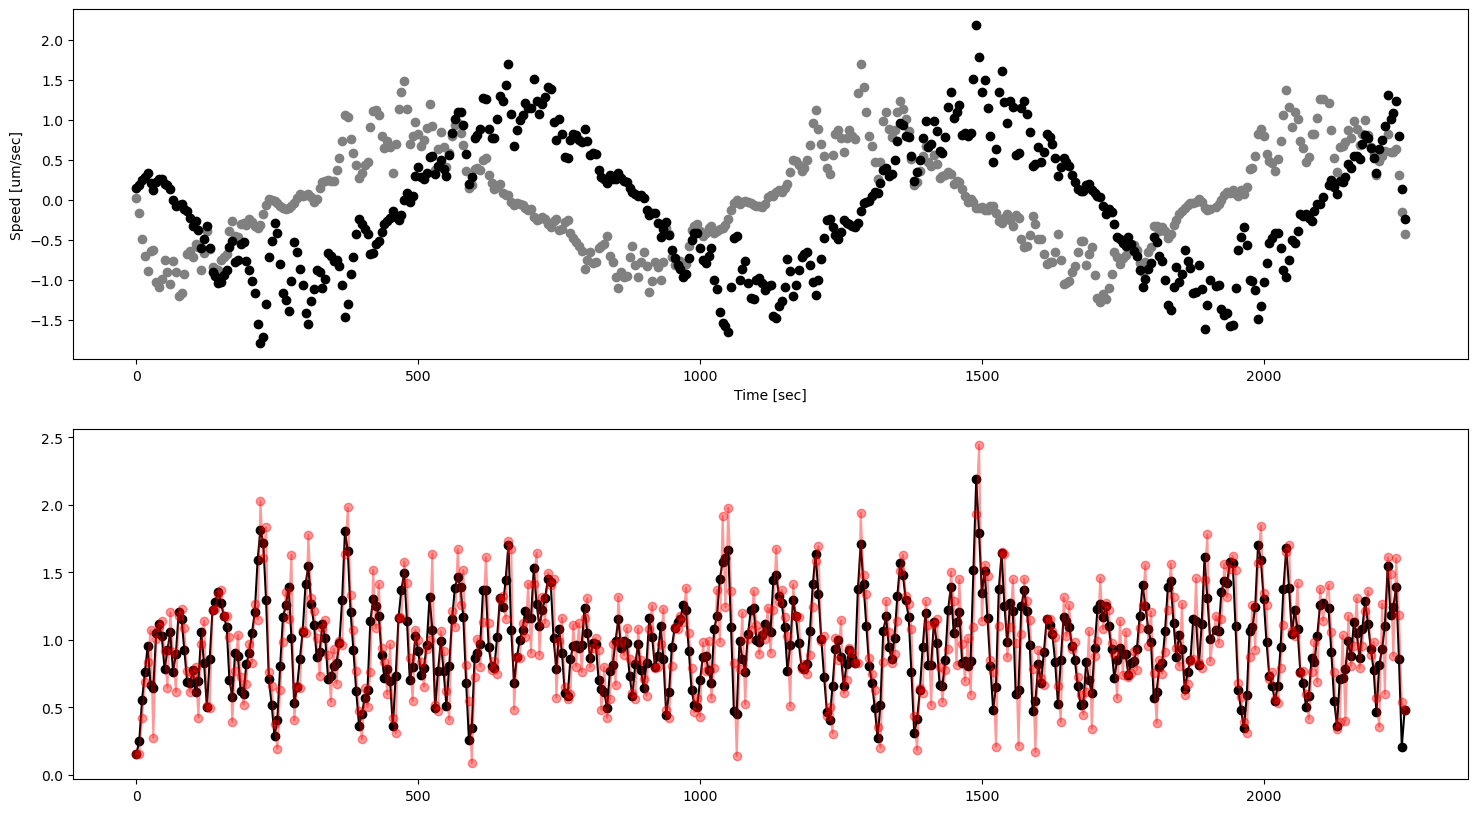

In [13]:
fig, ax = plt.subplots(2,1, figsize=(18,10))
ax[0].plot(time_pts_sec_noNan,v_x,'o',color='gray')
ax[0].plot(time_pts_sec_noNan,v_y,'o',color='k')
ax[1].plot(time_pts_sec_noNan,v,'o-',color='k')
ax[1].plot(time_pts_sec_noNan,v_alt,'o-',alpha=0.4,color='r')
ax[0].set_ylabel('Speed [um/sec]')
ax[0].set_xlabel('Time [sec]')


PLOT EXAMPLE FRAME, AND POSITION, SPEED, AND FILAMENT LENGTH FROM TIMELAPSE

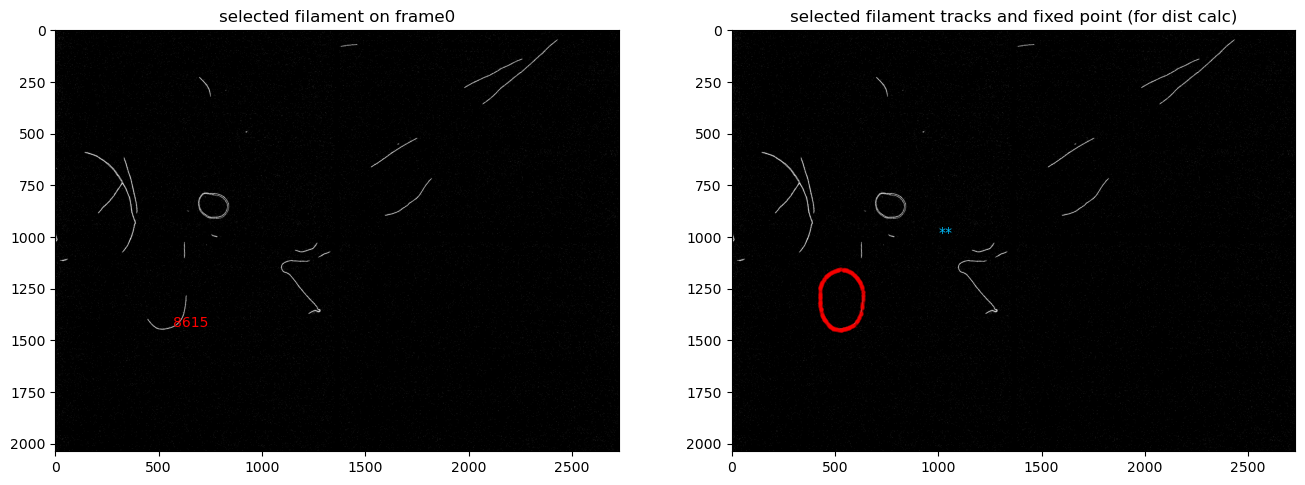

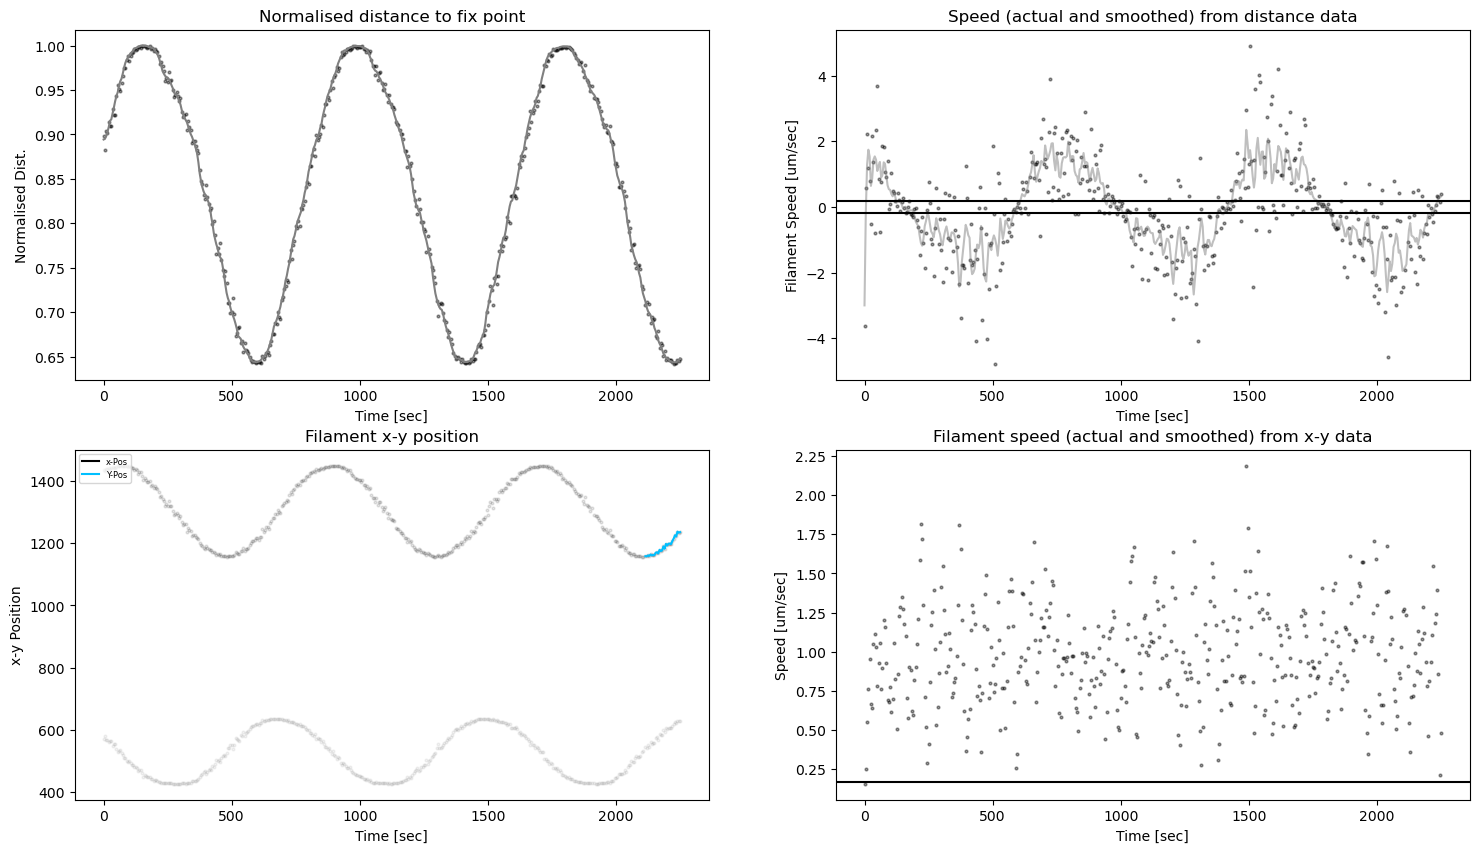

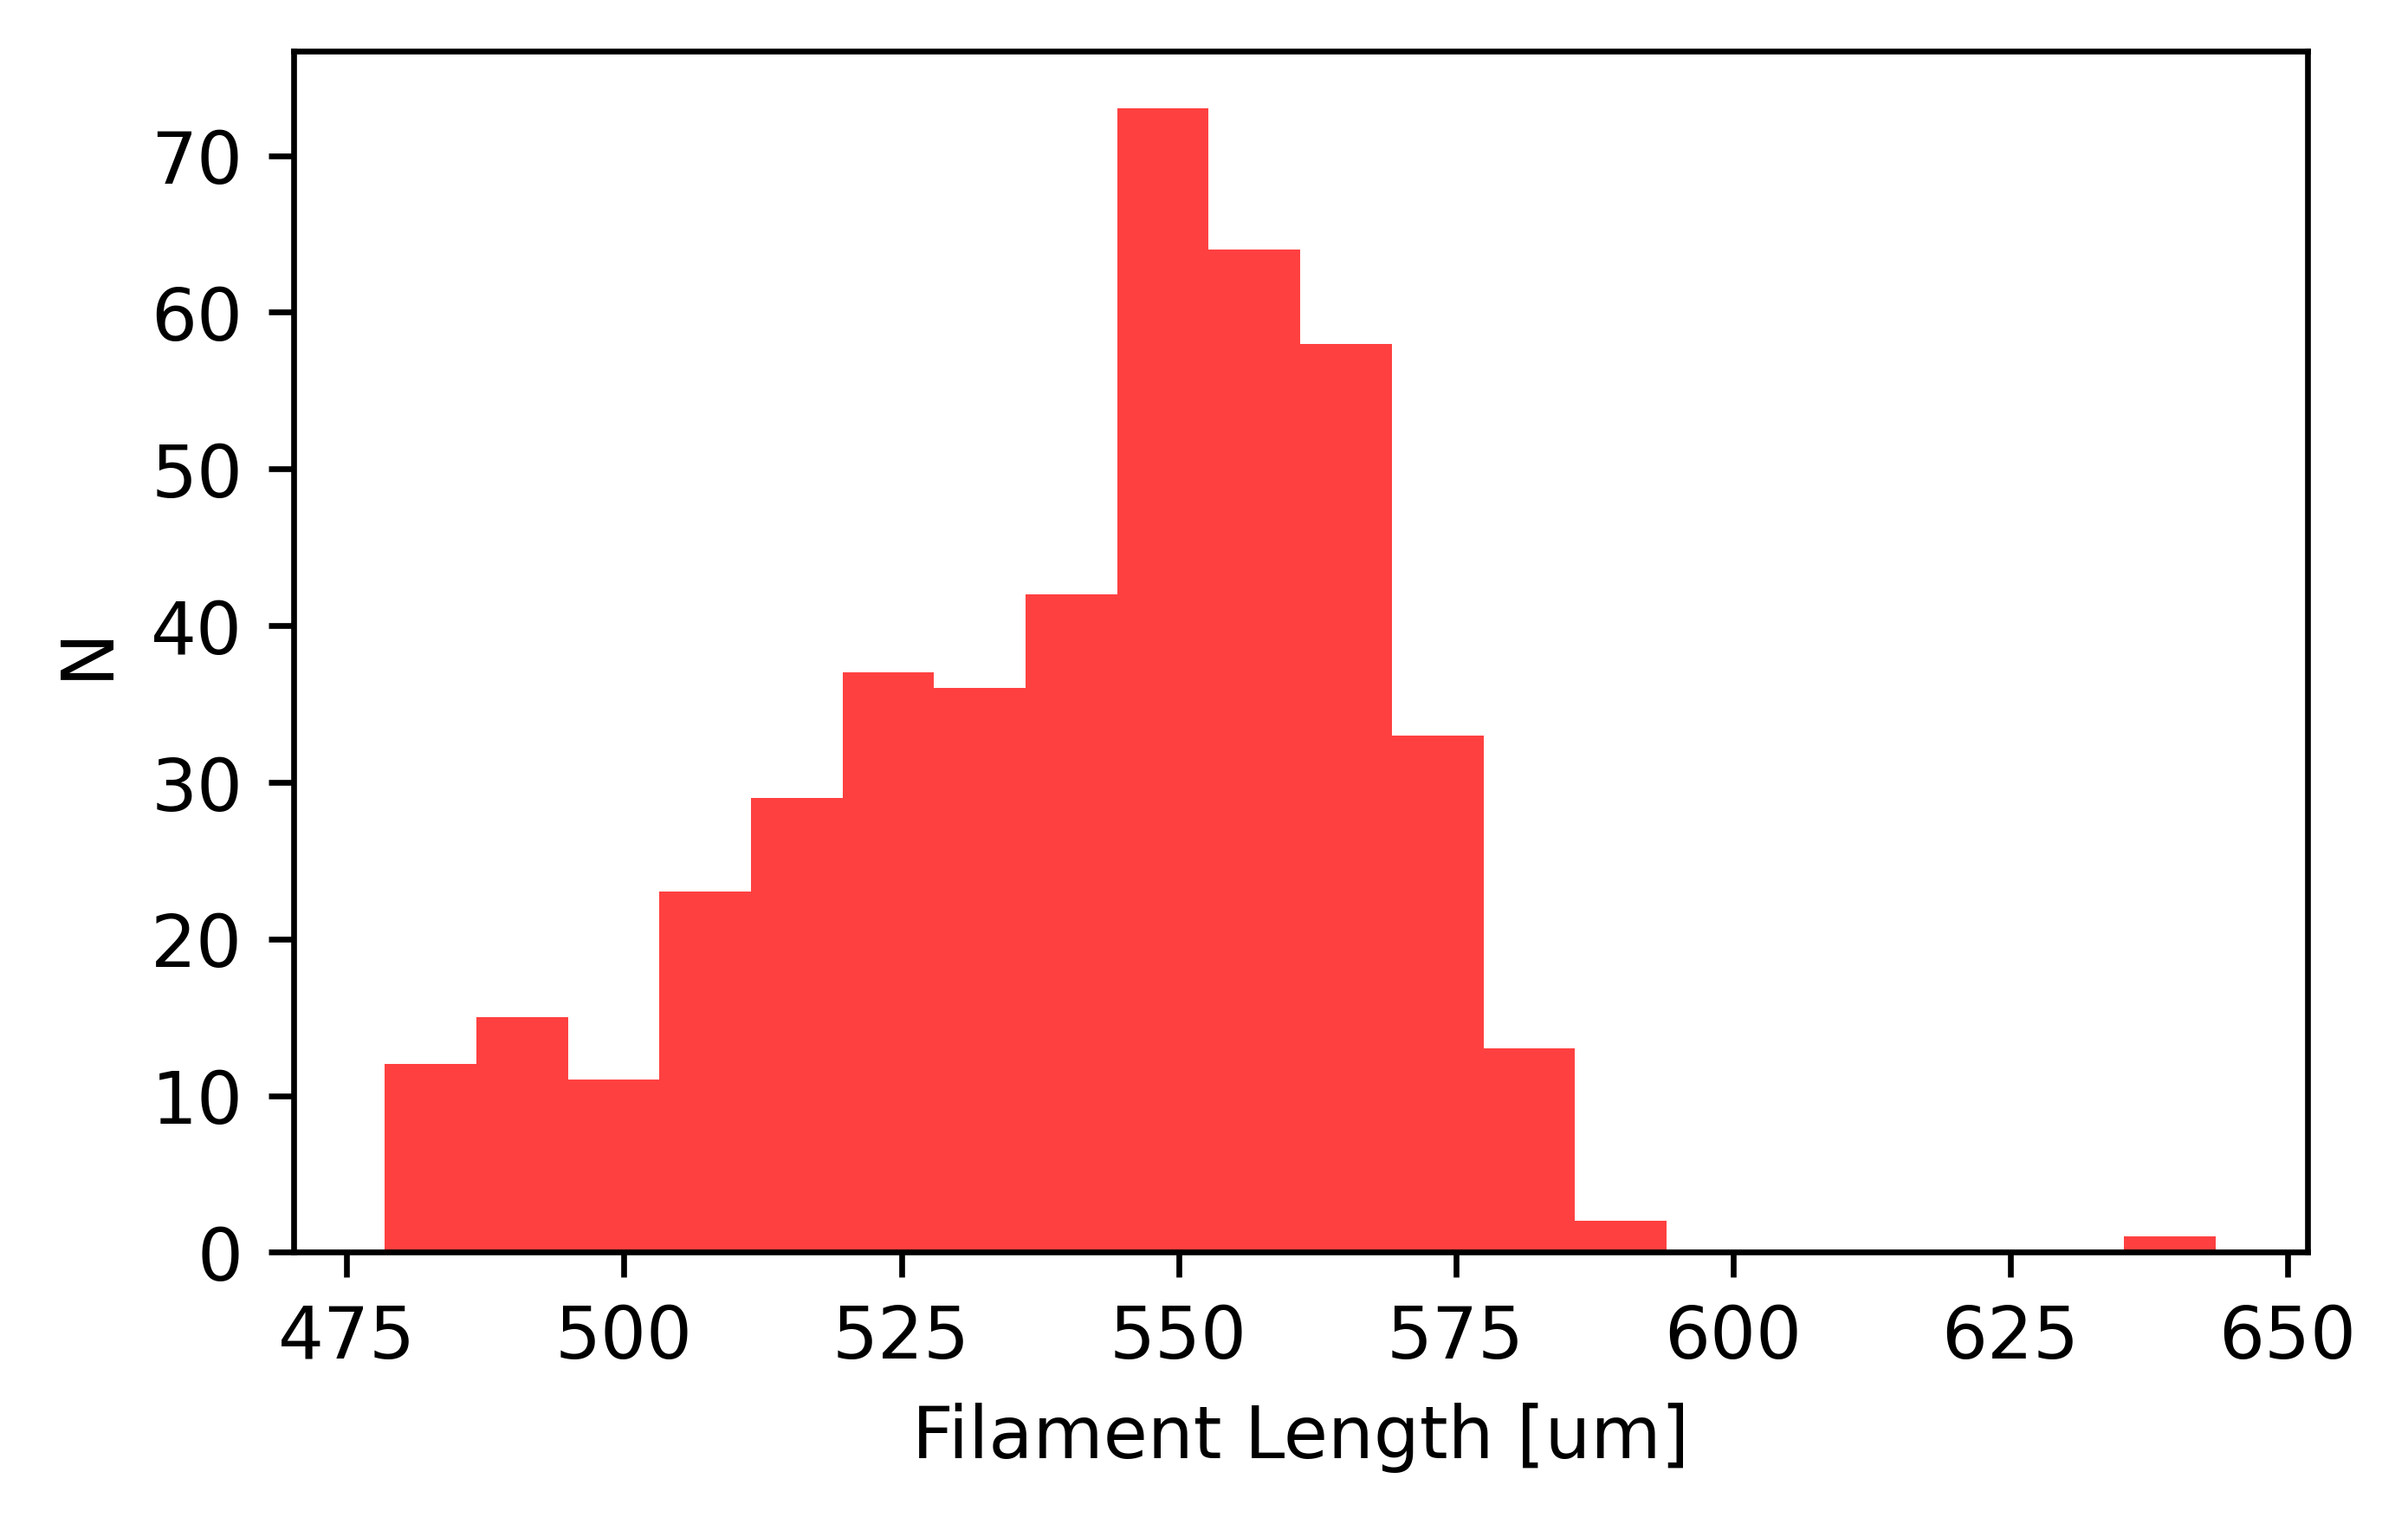

(2.189500982137545, 0.9626650122349043, 0.9761567516065438, 547.213209612341)

In [14]:

#plot filament with filament ID and its track
frame=frames[frameid]
thresh = sk_fil.threshold_yen(frame)  #returns a sensible threshold based on intenstity distribution: all values above threshold considered foreground (for black background images)
binary = frame > (coeffForThresh*thresh)          
frame_thresholded = binary*frame

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(frame_thresholded,cmap='gray')
ax[0].annotate(int(filamentData_overTime[0,1]),xy=(filamentData_overTime[0,3],filamentData_overTime[0,4]),color='r')  #mark filament id
ax[0].set_title(str('selected filament on frame'+str(frameid)))
ax[1].imshow(frame_thresholded,cmap='gray')
ax[1].annotate('**',xy=(fixedPoint[0],fixedPoint[1]),color='deepskyblue')  #mark used fixed point for dist calc.
for i in range(0,len(filamentData_overTime[:,3])):
    ax[1].scatter(filamentData_overTime[i,3],filamentData_overTime[i,4],color='r',marker='o',s=4,alpha=0.2)
ax[1].set_title(str('selected filament tracks and fixed point (for dist calc)'))

#save image file
saveFile_image = base+'_FILAMENTID_'+str(chosenFilamentID)+r'.png'
fig.savefig(saveFile_image)
plt.show()
plt.close(fig)



#plot filament position and speed raw and fitted (or smoothed) versions
fig, ax = plt.subplots(2,2, figsize=(18,10))

#position w.r.t a fixed point 
for i in range(0,len(time_smooth)):
    ax[0,0].scatter(time_pts_sec[i],posFilament_norm[i],s=4,marker='o',color='k',alpha=0.4)
ax[0,0].plot(time_pts_sec_noNan,pos_noNan_smooth_norm,'-',color='gray')
ax[0,0].set_ylabel('Normalised Dist.')
ax[0,0].set_xlabel('Time [sec]')
ax[0,0].set_title(str('Normalised distance to fix point'))

#speed w.r.t a fixed point 
for i in range(0,len(time_pts_sec)):
    ax[0,1].scatter(time_pts_sec[i],speedFilament[i],s=4,marker='o',color='k',alpha=0.4)
ax[0,1].plot(time_pts_sec_noNan,speed_noNan_smooth,'-',color='gray',alpha=0.5)
ax[0,1].axhline(y=speedThreshold_DwellTime, color='black', linestyle='-')
ax[0,1].axhline(y=-1*speedThreshold_DwellTime, color='black', linestyle='-')
ax[0,1].set_ylabel('Filament Speed [um/sec]')
ax[0,1].set_xlabel('Time [sec]')
ax[0,1].set_title(str('Speed (actual and smoothed) from distance data'))

#2D position and speed
for i in range(0,len(time_pts_sec_noNan)):
    ax[1,0].scatter(time_pts_sec_noNan[i],filamentData_overTime_x_noNan[i],s=4,marker='o',color='gray',alpha=0.1)
for i in range(0,len(time_pts_sec_noNan)):
    ax[1,0].scatter(time_pts_sec_noNan[i],filamentData_overTime_y_noNan[i],s=4,marker='o',color='k',alpha=0.1)
ax[1,0].plot(time_pts_sec, pos_x_extrapolated, '-', color='k', label='x-Pos')
ax[1,0].plot(time_pts_sec, pos_y_extrapolated, '-', color='deepskyblue',label='Y-Pos')
ax[1,0].set_ylabel('x-y Position')
ax[1,0].set_xlabel('Time [sec]')
ax[1,0].set_title(str('Filament x-y position'))
ax[1,0].legend(loc="upper left",fontsize=6)

for i in range(0,len(time_pts_sec_noNan)):
    ax[1,1].scatter(time_pts_sec_noNan[i],v[i],s=4,marker='o',color='k',alpha=0.4)
ax[1,1].plot(time_pts_sec,v_extrapolated,'-',color='gray')
ax[1,1].axhline(y=speedThreshold_DwellTime, color='black', linestyle='-')
ax[1,1].set_ylabel('Speed [um/sec]')
ax[1,1].set_xlabel('Time [sec]')
ax[1,1].set_title(str('Filament speed (actual and smoothed) from x-y data'))

##save pos plots
saveFile_pos_Speed = base+'_FILAMENTID_'+str(chosenFilamentID)+r'_pos_speed.png'
fig.savefig(saveFile_pos_Speed)
plt.show()
plt.close(fig)



#plot filament length from each frame as histogram - to make sure there is low variance
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=600)
ax.hist(filamentData_overTime[:,2],bins=20, density=False, alpha=0.75, color='red')
ax.set_ylabel('N')
ax.set_xlabel('Filament Length [um]')

###save length hist
saveFilamentLength = base+'_FILAMENTID_'+str(chosenFilamentID)+r'_lengthHist.png'
fig.savefig(saveFilamentLength)
plt.show()
plt.close(fig)


#calculate speed stats
#display max speed - to be inserted above (see parameter section) as analysis parameter
maxSpeed = max(np.abs(v))
medianSpeed = np.median(np.abs(v))
meanSpeed = np.mean(np.abs(v))
medianLength = np.nanmedian(filamentData_overTime[:,2])
maxSpeed, medianSpeed, meanSpeed, medianLength


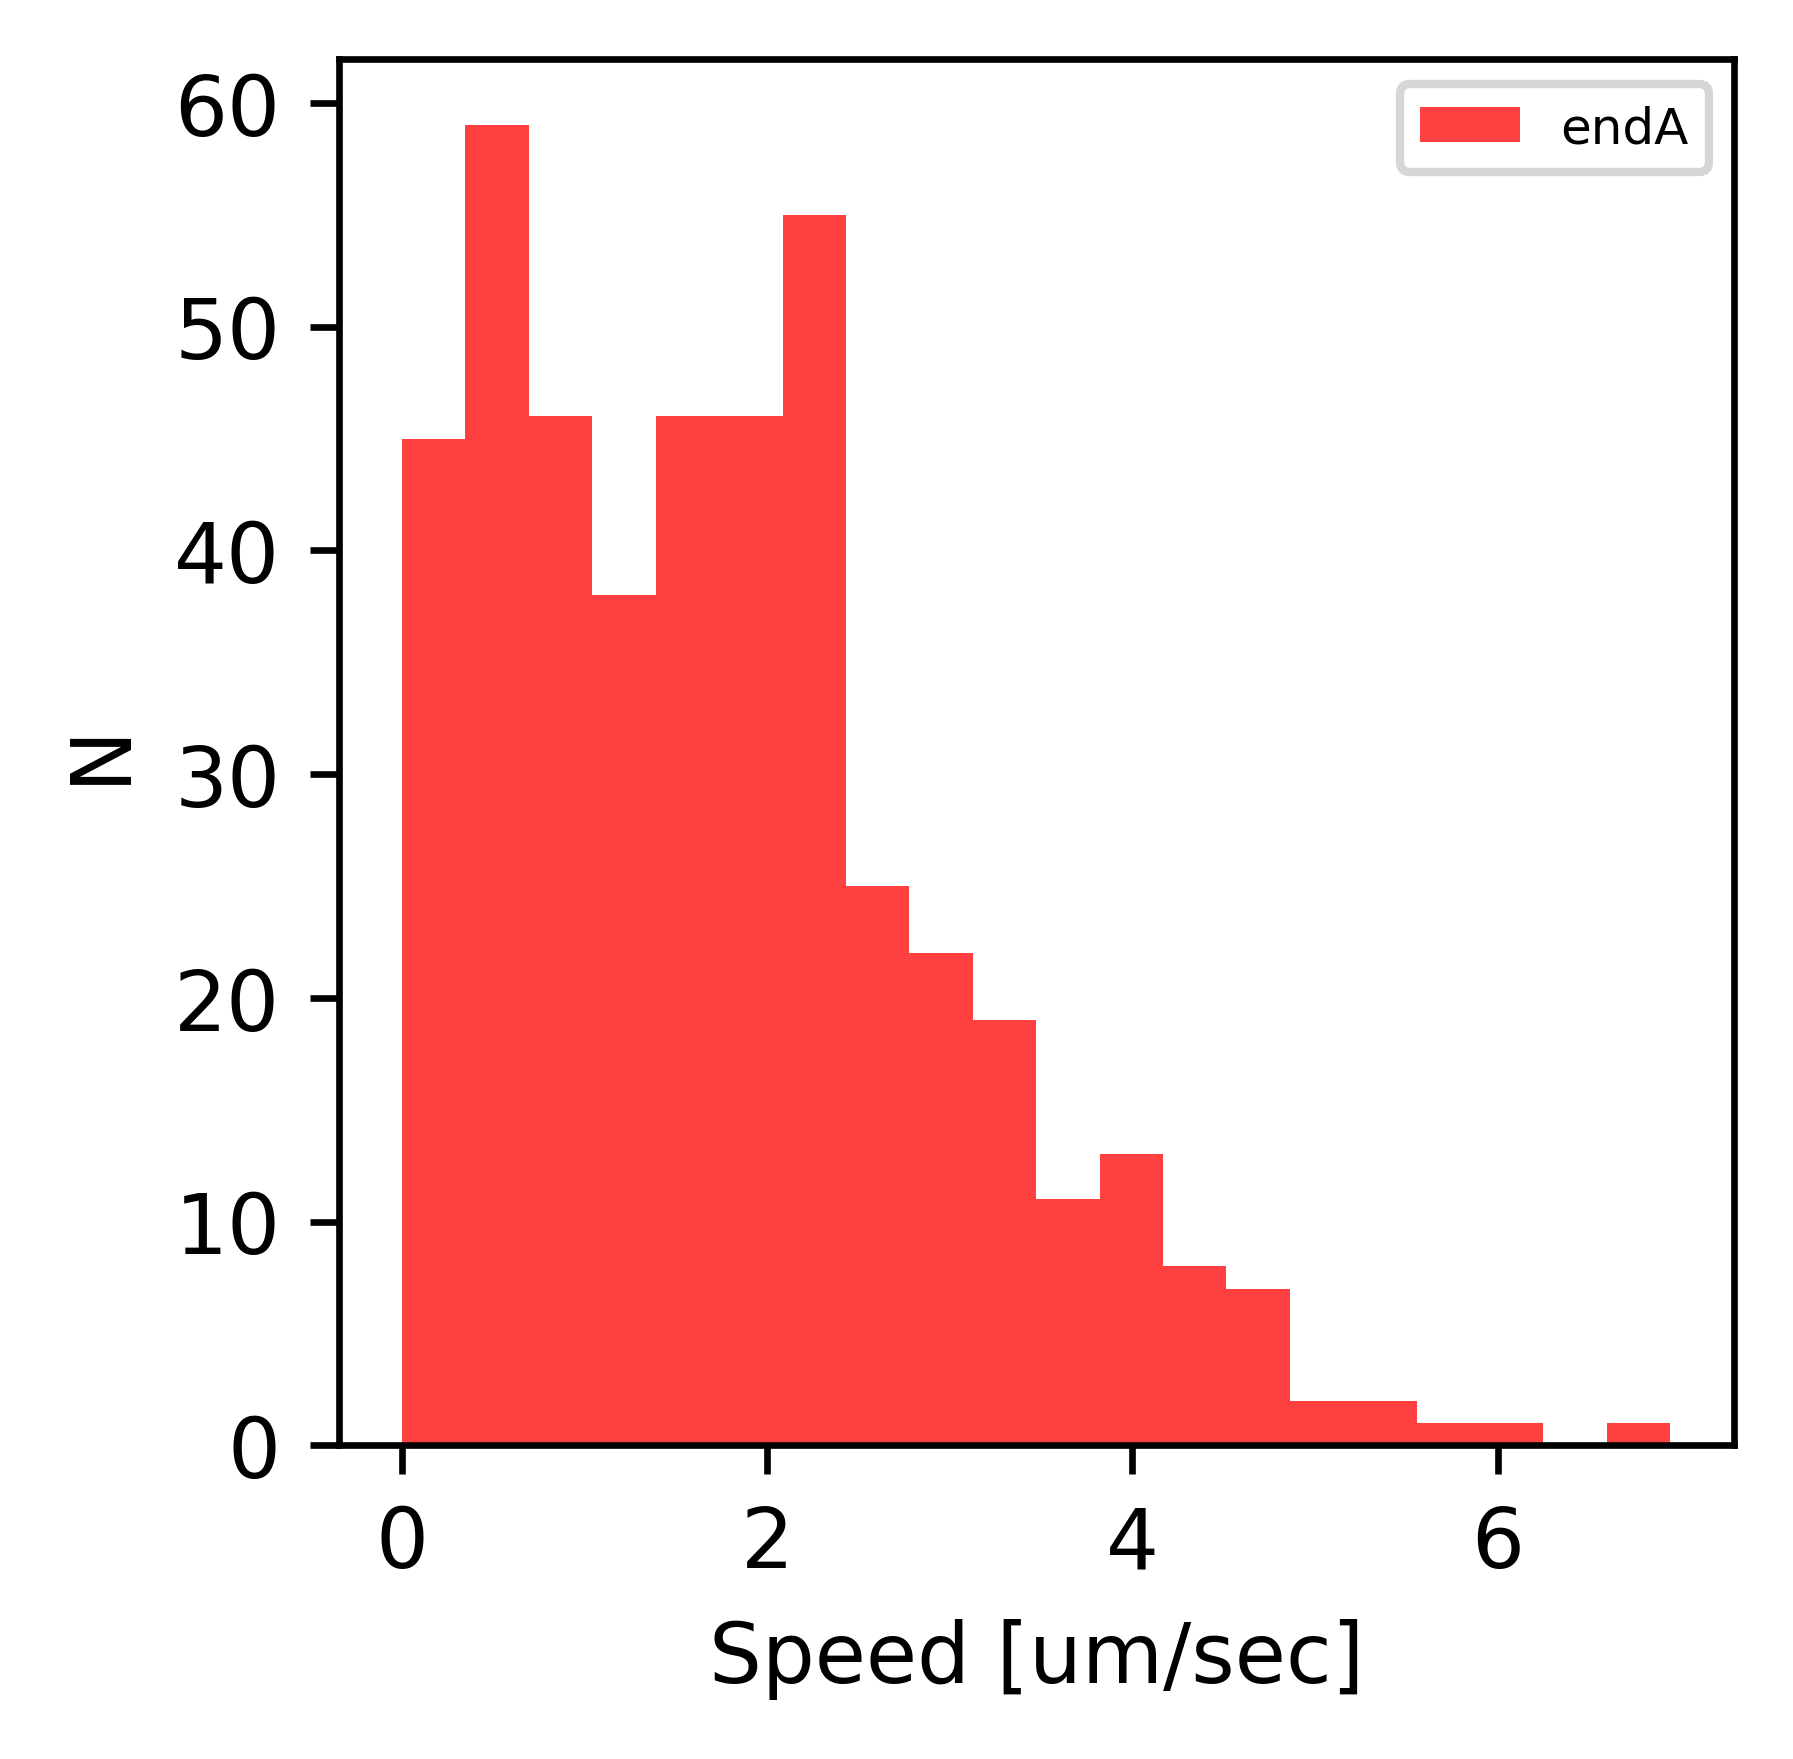

In [15]:
#calculate raw speed from  x- and y-pos 
v_x_raw = np.gradient(filamentData_overTime[:,3])*um_per_px/delta_t
v_y_raw = np.gradient(filamentData_overTime[:,4])*um_per_px/delta_t
v_raw = np.sqrt(v_x_raw**2+v_y_raw**2)

#plot speed distrubition
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=600)
ax.hist(v_raw,bins=20, density=False, alpha=0.75, color='red',label='endA')
ax.set_ylabel('N')
ax.set_xlabel('Speed [um/sec]')
#ax.set_yscale('log')
ax.legend(loc="upper right",fontsize=6)

saveSpeedDistr = base+'_FILAMENTID_'+str(chosenFilamentID)+r'_speedDistr.png'
fig.savefig(saveSpeedDistr)
plt.show()
plt.close(fig)

DWELL TIME CALCULATION USING SPEED 

In [17]:
#calculating stop duration during each reversal using speed data from above

#create arrays to hold an indication of whether speed was below or above threshold 
dumb1 = np.zeros(len(v))
dumb1[np.where(v<speedThreshold_DwellTime)]=-1
dumb1[np.where(v>speedThreshold_DwellTime)]=1 
#dumb1 = np.zeros(len(v_smooth))
#dumb1[np.where(v_smooth<speedThreshold_DwellTime)]=-1
#dumb1[np.where(v_smooth>speedThreshold_DwellTime)]=1 

#define some parameters to use in the processing and start processing speed data
k1 = 0
stopDurations = np.empty(shape=[0, 4])
dwelling = False
for counter in range(1,len(dumb1)):
    if (dwelling == False):
        if (dumb1[counter]*dumb1[counter-1]<0):      #location where speed was below threshold
            dwelling = True                           #first time we are here, so record this as beginning of stop
            startTime1 =  time_pts_sec[counter]
            continue
    if (dwelling == True):
        if (dumb1[counter]*dumb1[counter-1]<0):   #location where speed was above threshold and we have just been in a stop previously
            dwelling = False
            endTime1 = time_pts_sec[counter]             #record the previous point as end of stop.
            stopDurations = np.append(stopDurations, [[k1,endTime1-startTime1,startTime1,endTime1]], axis=0)
            k1=k1+1

stopDurations
#dumb1
#k1

array([], shape=(0, 4), dtype=float64)

PLOTTING DWELL TIME

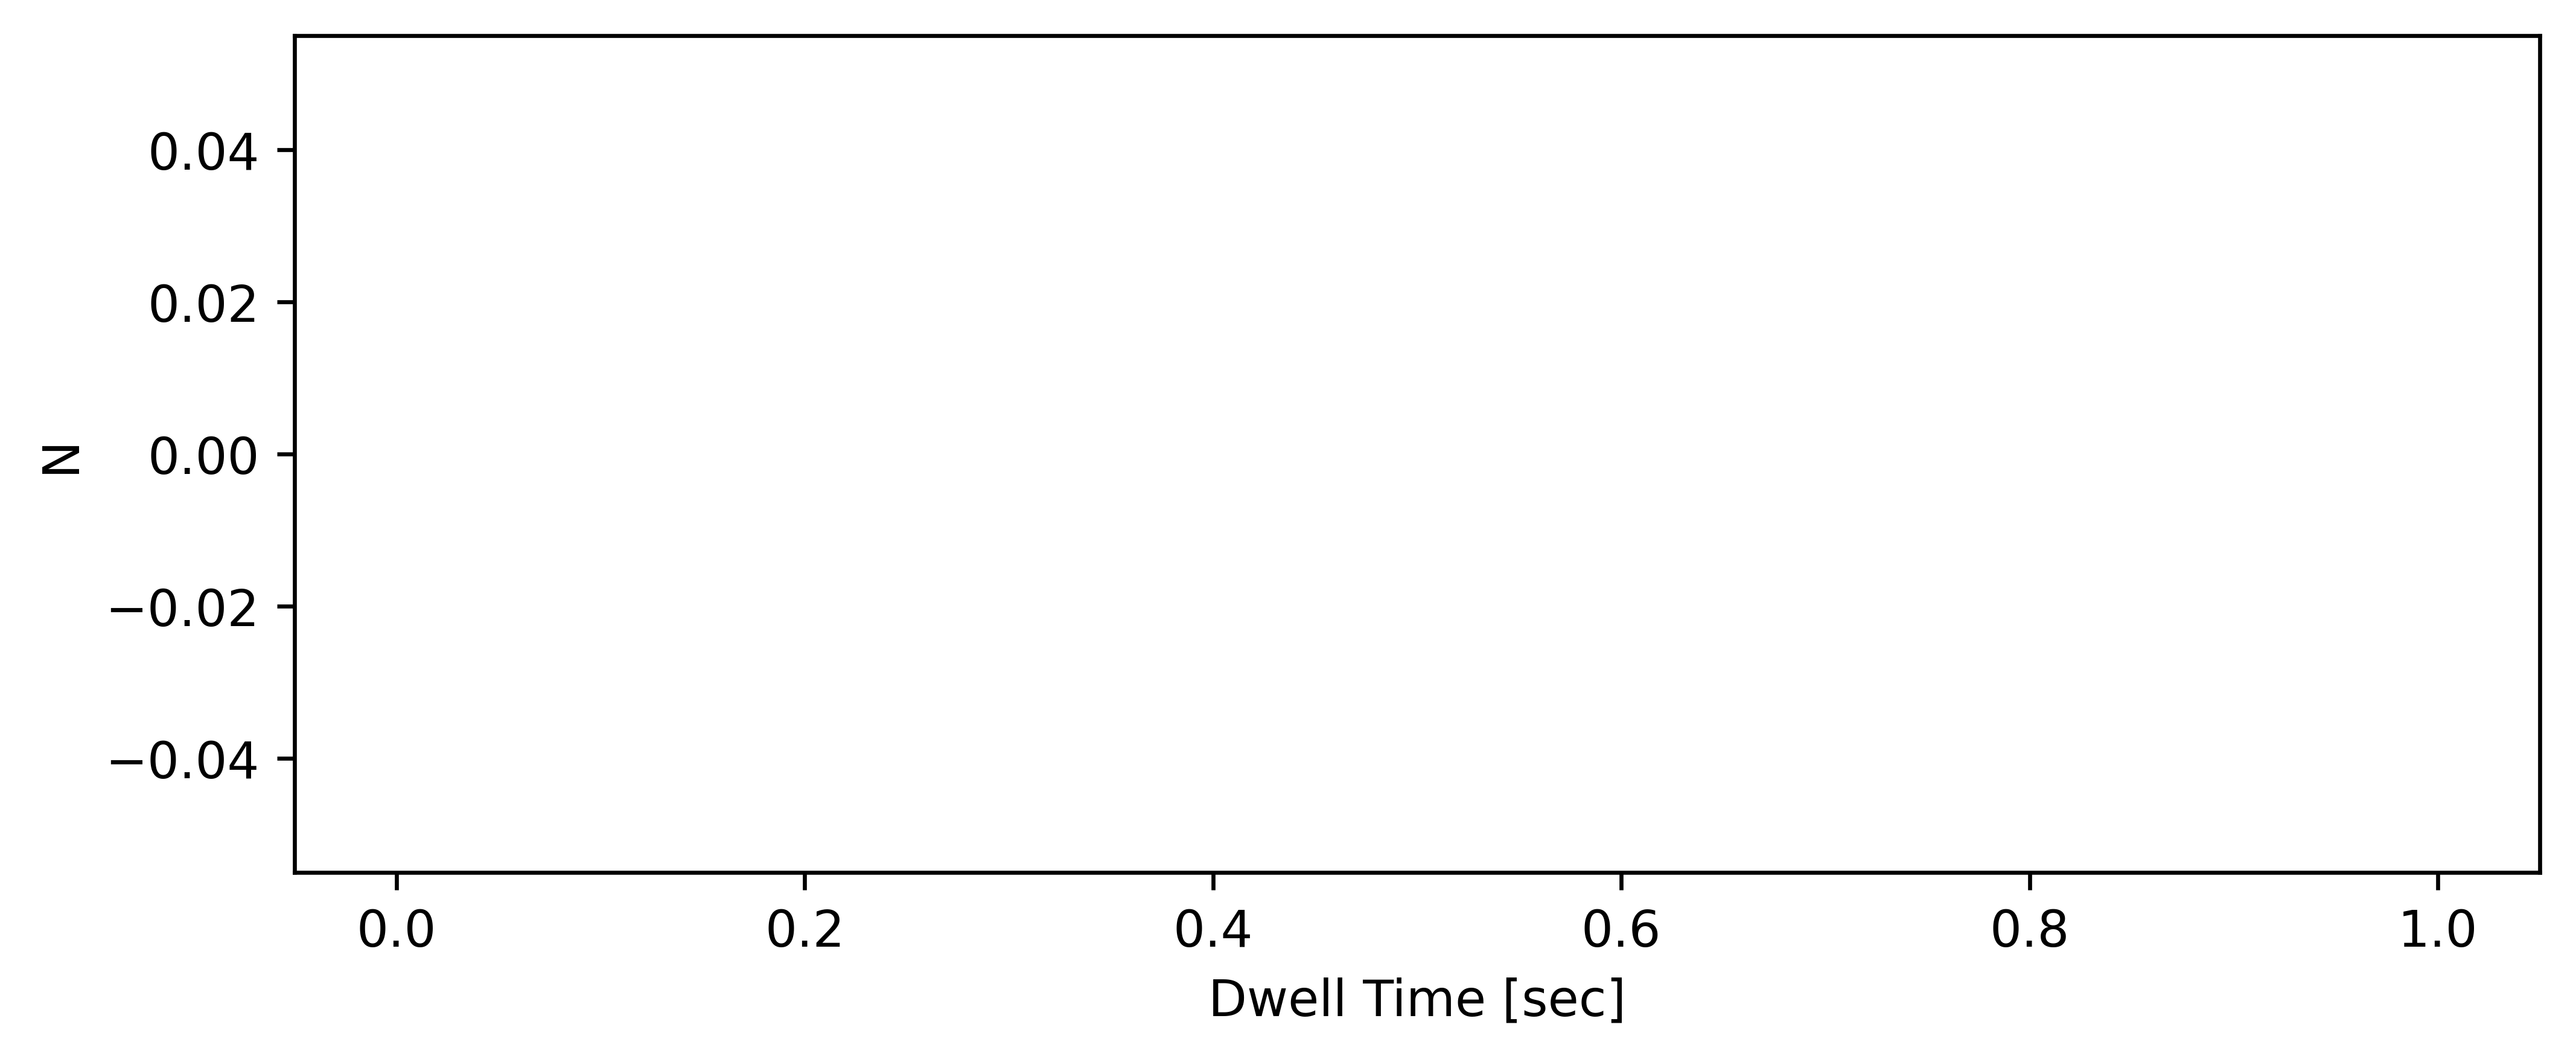

In [18]:

#plot dwell time as histogram
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=600)
ax.hist(stopDurations[:,1],bins=20, density=False, alpha=0.75, color='gray')
ax.set_ylabel('N')
ax.set_xlabel('Dwell Time [sec]')

###save length hist
saveFileHist = base+'_FILAMENTID_'+str(chosenFilamentID)+r'_dwellTimeHist.png'
fig.savefig(saveFileHist)
plt.show()
plt.close(fig)


PUT ALL OF THE THE DATA IN A FILE AND SAVE

In [19]:
# Prepare the results table
import pandas as pd
if (len(stopDurations[:,0])>0):
    result_dict = {'FilamentID' : chosenFilamentID, 'reversalID' : stopDurations[:,0],
            'dwellTime' : stopDurations[:,1], 'startTime' : stopDurations[:,2], 'endTime' : stopDurations[:,3],
            'MaxSpeed' : maxSpeed, 'MeanSpeed' : meanSpeed, 'MedianSpeed' : medianSpeed, 'MedianLength' : medianLength}
    result = pd.DataFrame.from_dict(result_dict)
else:
    dum = 0
    result_dict = {'FilamentID' : chosenFilamentID, 'reversalID' : dum,
               'dwellTime' : dum, 'startTime' : dum, 'endTime' : dum,
               'MaxSpeed' : maxSpeed, 'MeanSpeed' : meanSpeed, 'MedianSpeed' : medianSpeed, 'MedianLength' : medianLength}
    result = pd.DataFrame.from_dict([result_dict])
result.head()

saveMyData_dwellTime= base+'_FILAMENTID_'+str(chosenFilamentID)+r'_dwellTimeData.csv'
f = open(saveMyData_dwellTime, 'a')
f.write('#comments\n #path to data %s, Pixel Size Used %f, Delta t Used %f, coeffForThresh %f, smoothSpline %f, kOrderSpline %f, maxSpeedUsed %f, speedThreshold_DwellTime, %f, fixedPointUsed_x %f, fixedPointUsed_y %f \n' % (path, um_per_px, delta_t, coeffForThresh, smooth_spline, k_order_spline, maxSpeedUsed, speedThreshold_DwellTime, fixedPoint[0], fixedPoint[1]))

# ------------------ SAVE ---------------- #
result.to_csv(f, sep='\t')
f.close()

